In [6]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


38951745

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [2]:
PATH = "./" #CHANGE THIS - path where the pickled data is stored


with open(os.path.join(PATH, "sig_data_train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)

print("X's length {}".format(len(X)))

# print("training alphabets")  
# print("X's shape {}".format(X.shape))
# print("training alphabets")
# print(c.keys())
print("validation alphabets:")
print(cval.keys())

X's length 806
validation alphabets:
dict_keys(['Oriya', 'ULOG', 'Tengwar', 'Malayalam', 'Atlantean', 'Keble', 'Manipuri', 'Gurmukhi', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Angelic', 'Old_Church_Slavonic_(Cyrillic)', 'Kannada', 'Avesta', 'Mongolian', 'Syriac_(Serto)', 'Atemayar_Qelisayer', 'Sylheti', 'Glagolitic'])


In [3]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["sig_data_train", "val"]):
        self.data = {}
        self.author_dict = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,a) = pickle.load(f)
                self.data[name] = X
                self.author_dict[name] = a

    def get_batch(self,batch_size,s="sig_data_train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        author_dict = self.author_dict[s]
        sig_examples = len(X)
        author_examples = len(author_dict)
        w,h = X[0].shape

        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.ones((batch_size,))
        targets[batch_size//2:] = 0
        
        i = 0
        #pick images from same author for the first half input
        while i < batch_size // 2:
            author_id = rng.choice(list(author_dict))
            num_of_index = len(author_dict[author_id])
            if num_of_index <= 1:
                continue
            else:                
                idx_1 = rng.randint(0, num_of_index)
                idx_2 = rng.randint(0, num_of_index)
                pairs[0][i,:,:,:] = X[author_dict[author_id][idx_1]].reshape(w, h, 1)
                pairs[1][i,:,:,:] = X[author_dict[author_id][idx_2]].reshape(w, h, 1)
                i += 1

        #pick images from differnt author for the second half input
        while i < batch_size:
            author_id_1 = rng.choice(list(author_dict))
            author_id_2 = rng.choice(list(author_dict))
            if author_id_1 == author_id_2:
                continue
            else:
                num_of_index_1 = len(author_dict[author_id_1])
                num_of_index_2 = len(author_dict[author_id_2])
                idx_1 = rng.randint(0, num_of_index_1)
                idx_2 = rng.randint(0, num_of_index_2)
                pairs[0][i,:,:,:] = X[author_dict[author_id_1][idx_1]].reshape(w, h, 1)
                pairs[1][i,:,:,:] = X[author_dict[author_id_2][idx_2]].reshape(w, h, 1)
                i += 1
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot_ori(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def test_oneshot(self,model,size,s="sig_data_train"):
        print("Evaluating accuracy......")
        inputs, targets = self.get_batch(size,s)
        #inputs, targets = shuffle(inputs, targets)
        probs = model.predict(inputs)
        probs = probs > 0.5
        probs = probs.reshape(1,size)
        print("probs in test_oneshot {}".format(probs))
        print("targets in test_oneshot {}".format(targets))
        print("probs == targets in test_oneshot {}".format(probs == targets))
        corrects = np.sum(probs == targets)
        print("corrects in test_oneshot {}".format(corrects))
        
        percent_correct = (100.0 * corrects / size)
        print("Got an average of {}%  one-shot learning accuracy".format(percent_correct))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)
pairs,target = loader.get_batch(10)
print("No of pairs0 {}".format(len(pairs[0])))
print("No of pairs1 {}".format(len(pairs[1])))
print("target {}".format(target))

loading data from ./sig_data_train.pickle
loading data from ./val.pickle
No of pairs0 10
No of pairs1 10
target [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]


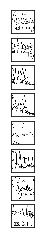

In [4]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task_original(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_batch_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8)
    
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)

    ax2.matshow(pairs[1][0].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    
    ax3.matshow(pairs[0][4].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax3.get_yaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)

    ax4.matshow(pairs[1][4].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax4.get_yaxis().set_visible(False)
    ax4.get_xaxis().set_visible(False)

    ax5.matshow(pairs[0][5].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax5.get_yaxis().set_visible(False)
    ax5.get_xaxis().set_visible(False)

    ax6.matshow(pairs[1][5].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax6.get_yaxis().set_visible(False)
    ax6.get_xaxis().set_visible(False)

    
    ax7.matshow(pairs[0][9].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax7.get_yaxis().set_visible(False)
    ax7.get_xaxis().set_visible(False)

    ax8.matshow(pairs[1][9].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax8.get_yaxis().set_visible(False)
    ax8.get_xaxis().set_visible(False)

    plt.xticks([])
    plt.yticks([])
    plt.show()

    
#example of a one-shot learning task
# pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
# plot_oneshot_task(pairs)

pairs, targets = loader.get_batch(10)
plot_batch_task(pairs)


In [9]:

#Training loop
print("!")
evaluate_every = 100 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 600
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(0, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    
    start_time = time.time()
    loss=siamese_net.train_on_batch(inputs,targets)
    elapsed_time = time.time() - start_time
    print("Training time: {} seconds".format(elapsed_time))
    
    print(loss)
    if i % evaluate_every == 0:
        
        start_time = time.time()
        val_acc = loader.test_oneshot(siamese_net,300,"sig_data_train")
        elapsed_time = time.time() - start_time
        print("Evaluation time: {} seconds".format(elapsed_time))
        
        if val_acc >= best:
            print("saving")
            
            start_time = time.time()
            siamese_net.save(weights_path)
            elapsed_time = time.time() - start_time
            print("Savinging time: {} seconds".format(elapsed_time))

            best=val_acc

#     if i % loss_every == 0:
#         print("iteration {}, training loss: {:.2f},".format(i,loss))


!
training
Training time: 3.7008109092712402 seconds
3.1011617
Evaluating accuracy......
probs in test_oneshot [[ True  True  True  True  True False  True  True False  True  True  True
  False  True  True False False  True  True False  True  True  True False
   True  True  True  True  True  True  True  True  True  True False False
   True  True  True  True  True  True  True  True False  True False  True
   True False  True  True  True  True False  True False  True  True  True
   True  True  True  True  True False  True  True  True False  True  True
   True False  True  True  True False  True  True  True  True  True False
   True  True False  True  True  True  True  True  True  True  True  True
   True  True False  True  True  True False  True  True False  True  True
   True  True False  True False  True  True  True  True  True False  True
   True  True  True  True  True False  True  True  True  True  True  True
   True  True False  True  True  True  True  True  True  True  True  True
 

Training time: 3.7788329124450684 seconds
2.443471
Training time: 3.6870980262756348 seconds
2.56449
Training time: 3.731569766998291 seconds
2.469394
Training time: 3.87833309173584 seconds
2.4420614
Training time: 4.2960851192474365 seconds
2.415843
Training time: 3.9591622352600098 seconds
2.5773466
Training time: 3.743187189102173 seconds
2.4131923
Training time: 3.948108196258545 seconds
2.4390433
Training time: 3.755249261856079 seconds
2.3996906
Training time: 4.011934995651245 seconds
2.4038963
Training time: 4.184009075164795 seconds
2.3836946
Training time: 3.9350311756134033 seconds
2.438701
Training time: 4.159335136413574 seconds
2.5599082
Training time: 3.841904878616333 seconds
2.4139416
Training time: 3.9728970527648926 seconds
2.3444188
Training time: 3.9148430824279785 seconds
2.3145757
Training time: 4.02997088432312 seconds
2.499585
Training time: 4.295278787612915 seconds
2.3413794
Training time: 4.166966915130615 seconds
2.4058356
Training time: 4.403936147689819 

Training time: 4.00843620300293 seconds
2.0613277
Training time: 3.9151458740234375 seconds
2.0877724
Training time: 3.9588308334350586 seconds
2.0449386
Training time: 4.021532297134399 seconds
2.0630605
Training time: 4.377551794052124 seconds
2.146535
Training time: 4.242109060287476 seconds
2.0603724
Training time: 4.36768102645874 seconds
2.038749
Training time: 3.949357748031616 seconds
2.2334797
Training time: 3.9202382564544678 seconds
2.0352697
Training time: 3.6939778327941895 seconds
2.0097077
Training time: 3.7376811504364014 seconds
2.086418
Training time: 3.7062411308288574 seconds
2.0821176
Training time: 3.7325682640075684 seconds
1.9841198
Training time: 4.024312257766724 seconds
2.0820346
Training time: 3.7301440238952637 seconds
2.0955176
Training time: 3.7088708877563477 seconds
2.1143706
Training time: 3.7522010803222656 seconds
1.9710941
Training time: 4.297181129455566 seconds
2.0193572
Training time: 3.6529929637908936 seconds
1.9948319
Training time: 3.71268391

Savinging time: 0.9822962284088135 seconds
Training time: 3.923159122467041 seconds
1.8684548
Training time: 4.104578971862793 seconds
1.7446767
Training time: 4.2196619510650635 seconds
1.8280468
Training time: 4.018458843231201 seconds
1.7215931
Training time: 3.754642963409424 seconds
1.7693317
Training time: 3.815988063812256 seconds
1.8280896
Training time: 3.943336248397827 seconds
1.91396
Training time: 3.8501691818237305 seconds
1.7400366
Training time: 3.7748050689697266 seconds
1.7741814
Training time: 3.9622249603271484 seconds
1.7119792
Training time: 4.281724214553833 seconds
1.7838227
Training time: 4.2159459590911865 seconds
1.8246077
Training time: 4.165295839309692 seconds
1.6726549
Training time: 4.151630878448486 seconds
1.72122
Training time: 3.899570941925049 seconds
1.7463592
Training time: 3.910433053970337 seconds
1.71205
Training time: 4.494518995285034 seconds
1.9177179
Training time: 5.062964916229248 seconds
1.6671306
Training time: 4.280119180679321 seconds

Savinging time: 0.9716947078704834 seconds
Training time: 3.753790855407715 seconds
1.622783
Training time: 3.8135480880737305 seconds
1.5578026
Training time: 3.862907886505127 seconds
1.4660002
Training time: 4.787482738494873 seconds
1.5432298
Training time: 4.3466620445251465 seconds
1.5957226
Training time: 3.889998197555542 seconds
1.4418031
Training time: 4.25590705871582 seconds
1.6283498
Training time: 3.868989944458008 seconds
1.4304317
Training time: 4.298367023468018 seconds
1.5199225
Training time: 4.109831094741821 seconds
1.4450513
Training time: 3.9130499362945557 seconds
1.5958427
Training time: 4.139545202255249 seconds
1.6315148
Training time: 4.317943096160889 seconds
1.5406506
Training time: 3.9906907081604004 seconds
1.443657
Training time: 4.3497679233551025 seconds
1.4700612
Training time: 4.40885591506958 seconds
1.4177595
Training time: 4.053886890411377 seconds
1.5215877
Training time: 4.1995110511779785 seconds
1.493614
Training time: 4.135216951370239 secon

Savinging time: 0.910491943359375 seconds
Training time: 3.913411855697632 seconds
1.5258596
Training time: 3.975343942642212 seconds
1.36271
Training time: 4.03902006149292 seconds
1.2625877
Training time: 4.481699705123901 seconds
1.3174112
Training time: 4.14668607711792 seconds
1.3891786
Training time: 3.8919601440429688 seconds
1.3538656
Training time: 3.9295711517333984 seconds
1.5270423
Training time: 3.9813270568847656 seconds
1.429351
Training time: 4.372395038604736 seconds
1.3284781
Training time: 4.212997198104858 seconds
1.3644423
Training time: 4.0181519985198975 seconds
1.2838432
Training time: 4.293781042098999 seconds
1.331137
Training time: 4.606706857681274 seconds
1.2731879
Training time: 4.78837776184082 seconds
1.3268641
Training time: 4.2644758224487305 seconds
1.3107163
Training time: 4.153307199478149 seconds
1.2555078
Training time: 4.033196926116943 seconds
1.3526052
Training time: 4.070380926132202 seconds
1.3964152
Training time: 4.765554904937744 seconds
1

Savinging time: 0.9513871669769287 seconds
Training time: 3.791454792022705 seconds
1.1364626
Training time: 3.9992709159851074 seconds
1.227003
Training time: 4.044764280319214 seconds
1.1978759
Training time: 4.247688055038452 seconds
1.1792324
Training time: 4.733330965042114 seconds
1.1697192
Training time: 4.880522966384888 seconds
1.1568125
Training time: 4.34001088142395 seconds
1.2159966
Training time: 4.2278361320495605 seconds
1.2079601
Training time: 4.154092788696289 seconds
1.1862394
Training time: 4.225013971328735 seconds
1.2022856
Training time: 3.773169755935669 seconds
1.2437965
Training time: 3.6906850337982178 seconds
1.1674852
Training time: 3.762050151824951 seconds
1.172404
Training time: 3.7657899856567383 seconds
1.186801
Training time: 3.7657601833343506 seconds
1.2700751
Training time: 3.784205198287964 seconds
1.189076
Training time: 3.7806758880615234 seconds
1.1452516
Training time: 3.726064920425415 seconds
1.1642311
Training time: 3.8019919395446777 seco

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [ ]:

a=test_nn_accuracy(3,500,loader)
print(a)